In [1]:
basepath='/blue/adamginsburg/adamginsburg/jwst/brick'

In [2]:
cd $basepath

/blue/adamginsburg/adamginsburg/jwst/brick


In [3]:
from astropy import coordinates

In [4]:
import numpy as np

In [5]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry


In [6]:
import warnings

In [7]:
import regions

In [8]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [9]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [10]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['figure.dpi'] = 100
pl.rcParams['font.size'] = 16

In [11]:
import glob
from astropy.io import fits

In [12]:
%run $basepath/analysis/analysis_setup.py

/orange/adamginsburg/jwst/brick//reduction/filtering.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [13]:
%run $basepath/analysis/selections.py --module=nrca

Selecting module nrca
1233 saturated in near_saturated_f212n_f212n
171 saturated in near_saturated_f466n_f466n
530 saturated in near_saturated_f405n_f405n
1060 saturated in near_saturated_f187n_f187n
7632 saturated in near_saturated_f182m_f182m
9717 near saturated out of 289206.  That leaves 279489 not near unsaturated
126 saturated in replaced_saturated_f212n
48 saturated in replaced_saturated_f466n
178 saturated in replaced_saturated_f405n
55 saturated in replaced_saturated_f187n
222 saturated in replaced_saturated_f182m
1312 saturated out of 289206.  That leaves 287894 unsaturated
Filter f410m has qf=29809, spread=68647, fracflux=47462 ok, totaling 23475.  There are 289206 total, of which 226777 are masked and 62429 are unmasked. qfmasksum=218116, inverse=71090.
Filter f212n has qf=53366, spread=123906, fracflux=101766 ok, totaling 45419.  There are 289206 total, of which 167569 are masked and 121637 are unmasked. qfmasksum=164843, inverse=124363.
Filter f466n has qf=23784, spread=5

In [14]:
blue_BrA_and_PaA.sum()

250

In [15]:
(blue_BrA_and_PaA & (basetable['mag_ab_f405n'] > 15)).sum()

142

In [16]:
blue_405_410.sum()

35

In [17]:
blue_405_410b.sum()

94

In [18]:
basetable[blue_BrA_and_PaA][:2]

skycoord_ref,sep_f410m,id_f410m,skycoord_f410m,x_f410m,y_f410m,flux_f410m,passno_f410m,dx_f410m,dy_f410m,dflux_f410m,qf_f410m,rchi2_f410m,fracflux_f410m,fluxlbs_f410m,dfluxlbs_f410m,fwhm_f410m,spread_model_f410m,dspread_model_f410m,fluxiso_f410m,xiso_f410m,yiso_f410m,sky_f410m,mask_f410m,flux_jy_f410m,eflux_jy_f410m,mag_ab_f410m,emag_ab_f410m,near_saturated_f410m_f410m,replaced_saturated_f410m,sep_f212n,id_f212n,skycoord_f212n,x_f212n,y_f212n,flux_f212n,passno_f212n,dx_f212n,dy_f212n,dflux_f212n,qf_f212n,rchi2_f212n,fracflux_f212n,fluxlbs_f212n,dfluxlbs_f212n,fwhm_f212n,spread_model_f212n,dspread_model_f212n,fluxiso_f212n,xiso_f212n,yiso_f212n,sky_f212n,mask_f212n,flux_jy_f212n,eflux_jy_f212n,mag_ab_f212n,emag_ab_f212n,near_saturated_f212n_f212n,replaced_saturated_f212n,sep_f466n,id_f466n,skycoord_f466n,x_f466n,y_f466n,flux_f466n,passno_f466n,dx_f466n,dy_f466n,dflux_f466n,qf_f466n,rchi2_f466n,fracflux_f466n,fluxlbs_f466n,dfluxlbs_f466n,fwhm_f466n,spread_model_f466n,dspread_model_f466n,fluxiso_f466n,xiso_f466n,yiso_f466n,sky_f466n,mask_f466n,flux_jy_f466n,eflux_jy_f466n,mag_ab_f466n,emag_ab_f466n,near_saturated_f466n_f466n,replaced_saturated_f466n,sep_f405n,id_f405n,skycoord_f405n,x_f405n,y_f405n,flux_f405n,passno_f405n,dx_f405n,dy_f405n,dflux_f405n,qf_f405n,rchi2_f405n,fracflux_f405n,fluxlbs_f405n,dfluxlbs_f405n,fwhm_f405n,spread_model_f405n,dspread_model_f405n,fluxiso_f405n,xiso_f405n,yiso_f405n,sky_f405n,mask_f405n,flux_jy_f405n,eflux_jy_f405n,mag_ab_f405n,emag_ab_f405n,near_saturated_f405n_f405n,replaced_saturated_f405n,sep_f187n,id_f187n,skycoord_f187n,x_f187n,y_f187n,flux_f187n,passno_f187n,dx_f187n,dy_f187n,dflux_f187n,qf_f187n,rchi2_f187n,fracflux_f187n,fluxlbs_f187n,dfluxlbs_f187n,fwhm_f187n,spread_model_f187n,dspread_model_f187n,fluxiso_f187n,xiso_f187n,yiso_f187n,sky_f187n,mask_f187n,flux_jy_f187n,eflux_jy_f187n,mag_ab_f187n,emag_ab_f187n,near_saturated_f187n_f187n,replaced_saturated_f187n,sep_f182m,id_f182m,skycoord_f182m,x_f182m,y_f182m,flux_f182m,passno_f182m,dx_f182m,dy_f182m,dflux_f182m,qf_f182m,rchi2_f182m,fracflux_f182m,fluxlbs_f182m,dfluxlbs_f182m,fwhm_f182m,spread_model_f182m,dspread_model_f182m,fluxiso_f182m,xiso_f182m,yiso_f182m,sky_f182m,mask_f182m,flux_jy_f182m,eflux_jy_f182m,mag_ab_f182m,emag_ab_f182m,near_saturated_f182m_f182m,replaced_saturated_f182m,flux_jy_410m405,mag_ab_410m405,flux_jy_405m410,mag_ab_405m410,flux_jy_182m187,mag_ab_182m187,flux_jy_187m182,mag_ab_187m182,good_f410m,good_f212n,good_f466n,good_f405n,good_f187n,good_f182m
"deg,deg",deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,Jy,,Jy,,Jy,,Jy,,,,,,,
SkyCoord,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,f

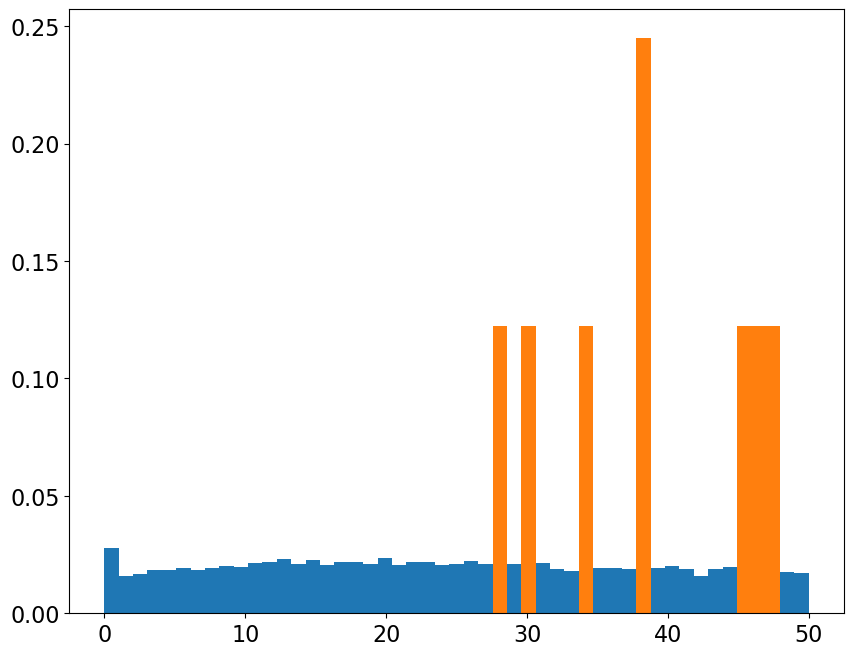

In [19]:
pl.hist(basetable['flux_f410m'] / basetable['dflux_f410m'], density=True, bins=np.linspace(0,50))
pl.hist((basetable['flux_f410m'] / basetable['dflux_f410m'])[blue_BrA_and_PaA], density=True, bins=np.linspace(0,50));

(array([139.53107119, 172.96098969, 200.92474251, 267.89965669,
        195.27853675, 212.08722821,  78.13739987,  83.71864271,
         22.31754706,  22.32497139]),
 array([3.1238246, 3.1245413, 3.1252582, 3.125975 , 3.1266916, 3.1274085,
        3.1281252, 3.1288419, 3.1295586, 3.1302755, 3.1309922],
       dtype=float32),
 <BarContainer object of 10 artists>)

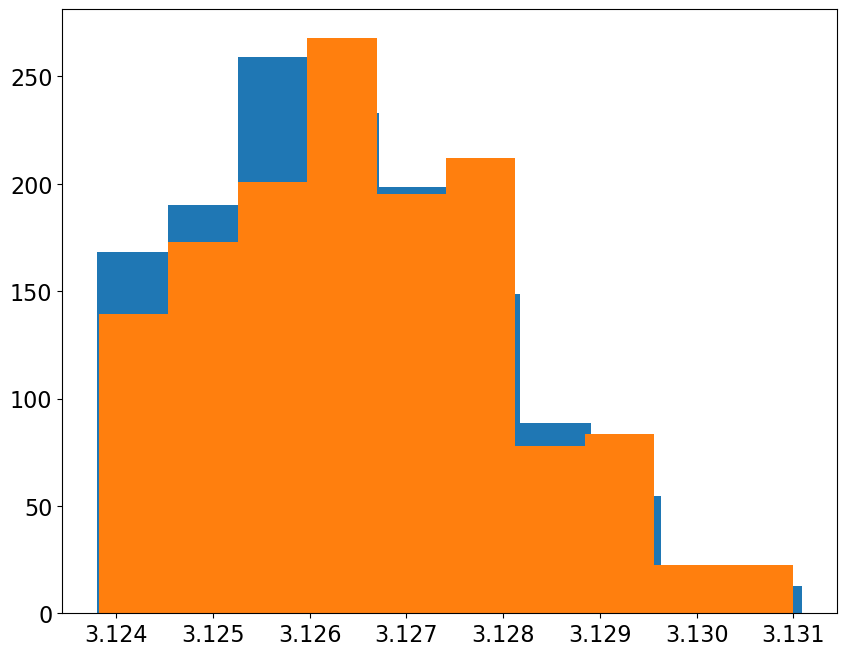

In [20]:
pl.hist(basetable['fwhm_f410m'], density=True)
pl.hist(basetable['fwhm_f410m'][blue_BrA_and_PaA], density=True)

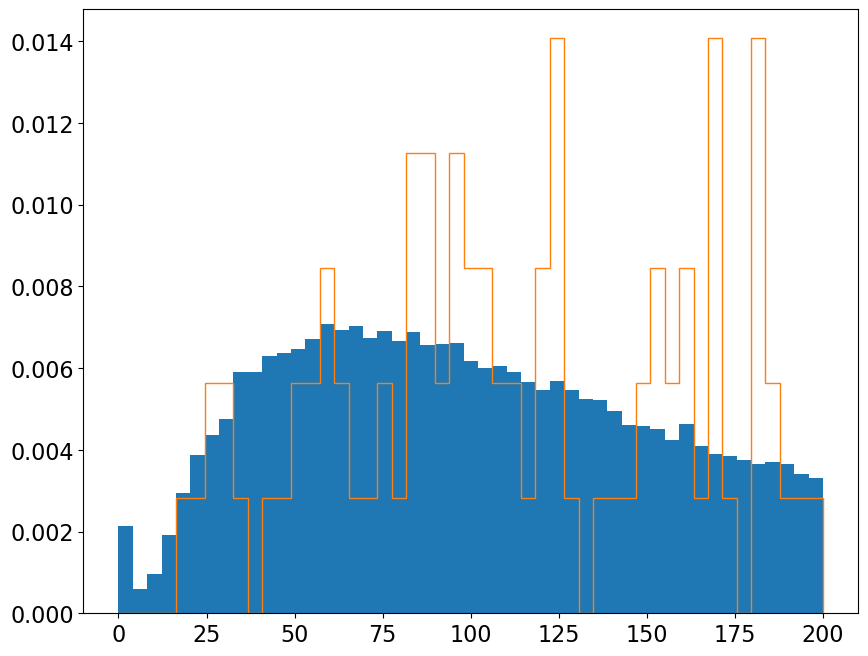

In [21]:
pl.hist(basetable['rchi2_f410m'], density=True, bins=np.linspace(0,200))
h,l,p = pl.hist(basetable['rchi2_f410m'][blue_BrA_and_PaA], density=True, bins=np.linspace(0,200), histtype='step');


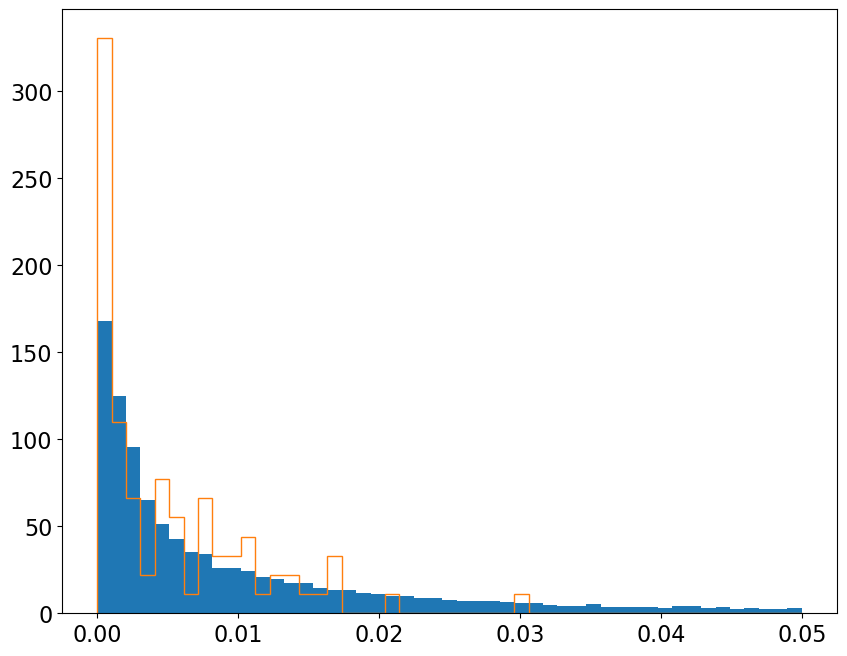

In [22]:
pl.hist(basetable['spread_model_f410m'], density=True, bins=np.linspace(0,0.05))
h,l,p = pl.hist(basetable['spread_model_f410m'][blue_BrA_and_PaA], density=True, bins=np.linspace(0,.05), histtype='step');

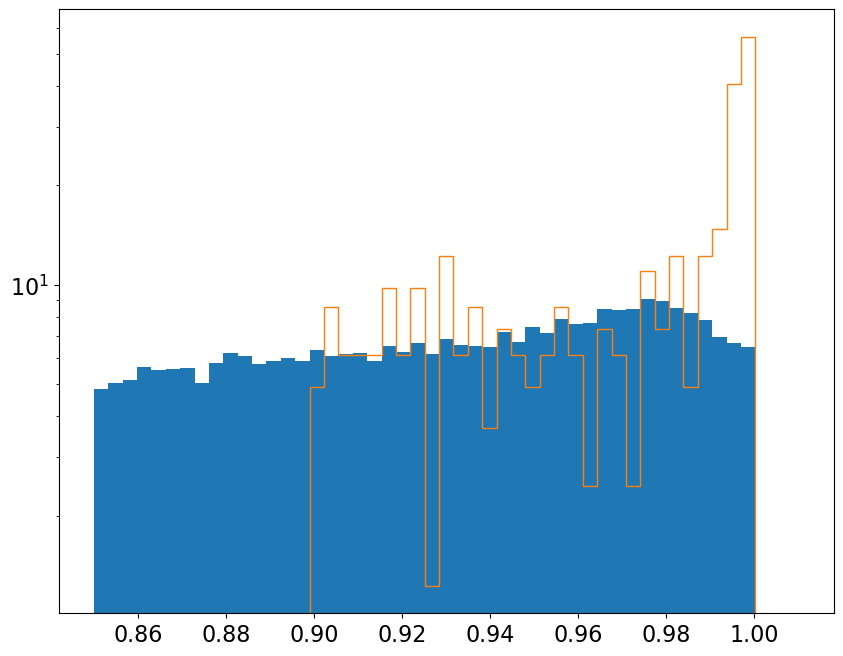

In [23]:
pl.hist(basetable['qf_f410m'], density=True, bins=np.linspace(0.85, 1.01), log=True)
pl.hist(basetable['qf_f410m'][blue_BrA_and_PaA], density=True, bins=np.linspace(0.85, 1.01), histtype='step', log=True);

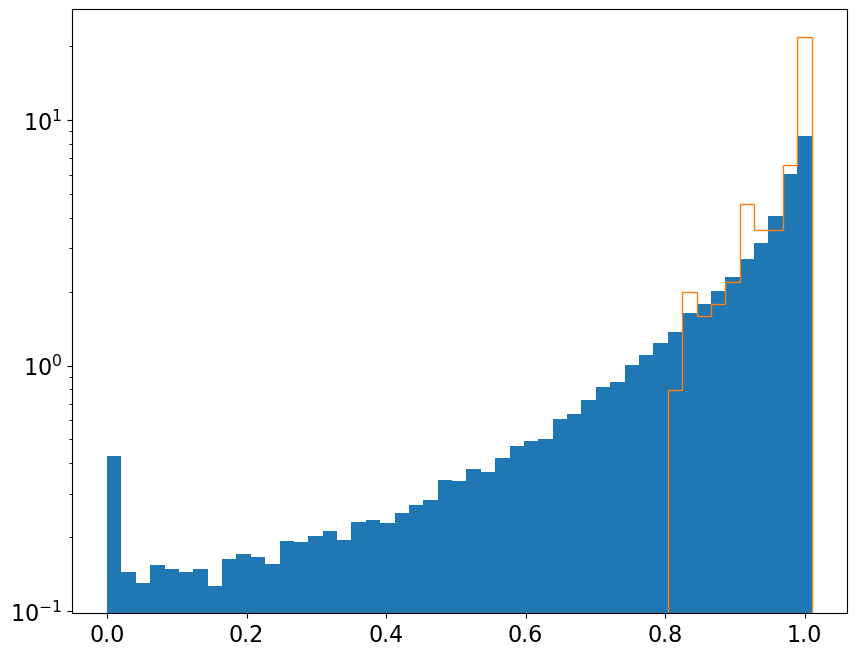

In [24]:
pl.hist(basetable['fracflux_f410m'], density=True, bins=np.linspace(0., 1.01), log=True)
pl.hist(basetable['fracflux_f410m'][blue_BrA_and_PaA], density=True, bins=np.linspace(0., 1.01), histtype='step', log=True);

In [25]:
basetable[blue_BrA_and_PaA].write(f'{basepath}/catalogs/crowdsource_nsky0_merged_photometry_tables_merged_BlueBrAandPaA.fits', overwrite=True)

In [26]:
basetable[blue_BrA_and_PaA][:5]

skycoord_ref,sep_f410m,id_f410m,skycoord_f410m,x_f410m,y_f410m,flux_f410m,passno_f410m,dx_f410m,dy_f410m,dflux_f410m,qf_f410m,rchi2_f410m,fracflux_f410m,fluxlbs_f410m,dfluxlbs_f410m,fwhm_f410m,spread_model_f410m,dspread_model_f410m,fluxiso_f410m,xiso_f410m,yiso_f410m,sky_f410m,mask_f410m,flux_jy_f410m,eflux_jy_f410m,mag_ab_f410m,emag_ab_f410m,near_saturated_f410m_f410m,replaced_saturated_f410m,sep_f212n,id_f212n,skycoord_f212n,x_f212n,y_f212n,flux_f212n,passno_f212n,dx_f212n,dy_f212n,dflux_f212n,qf_f212n,rchi2_f212n,fracflux_f212n,fluxlbs_f212n,dfluxlbs_f212n,fwhm_f212n,spread_model_f212n,dspread_model_f212n,fluxiso_f212n,xiso_f212n,yiso_f212n,sky_f212n,mask_f212n,flux_jy_f212n,eflux_jy_f212n,mag_ab_f212n,emag_ab_f212n,near_saturated_f212n_f212n,replaced_saturated_f212n,sep_f466n,id_f466n,skycoord_f466n,x_f466n,y_f466n,flux_f466n,passno_f466n,dx_f466n,dy_f466n,dflux_f466n,qf_f466n,rchi2_f466n,fracflux_f466n,fluxlbs_f466n,dfluxlbs_f466n,fwhm_f466n,spread_model_f466n,dspread_model_f466n,fluxiso_f466n,xiso_f466n,yiso_f466n,sky_f466n,mask_f466n,flux_jy_f466n,eflux_jy_f466n,mag_ab_f466n,emag_ab_f466n,near_saturated_f466n_f466n,replaced_saturated_f466n,sep_f405n,id_f405n,skycoord_f405n,x_f405n,y_f405n,flux_f405n,passno_f405n,dx_f405n,dy_f405n,dflux_f405n,qf_f405n,rchi2_f405n,fracflux_f405n,fluxlbs_f405n,dfluxlbs_f405n,fwhm_f405n,spread_model_f405n,dspread_model_f405n,fluxiso_f405n,xiso_f405n,yiso_f405n,sky_f405n,mask_f405n,flux_jy_f405n,eflux_jy_f405n,mag_ab_f405n,emag_ab_f405n,near_saturated_f405n_f405n,replaced_saturated_f405n,sep_f187n,id_f187n,skycoord_f187n,x_f187n,y_f187n,flux_f187n,passno_f187n,dx_f187n,dy_f187n,dflux_f187n,qf_f187n,rchi2_f187n,fracflux_f187n,fluxlbs_f187n,dfluxlbs_f187n,fwhm_f187n,spread_model_f187n,dspread_model_f187n,fluxiso_f187n,xiso_f187n,yiso_f187n,sky_f187n,mask_f187n,flux_jy_f187n,eflux_jy_f187n,mag_ab_f187n,emag_ab_f187n,near_saturated_f187n_f187n,replaced_saturated_f187n,sep_f182m,id_f182m,skycoord_f182m,x_f182m,y_f182m,flux_f182m,passno_f182m,dx_f182m,dy_f182m,dflux_f182m,qf_f182m,rchi2_f182m,fracflux_f182m,fluxlbs_f182m,dfluxlbs_f182m,fwhm_f182m,spread_model_f182m,dspread_model_f182m,fluxiso_f182m,xiso_f182m,yiso_f182m,sky_f182m,mask_f182m,flux_jy_f182m,eflux_jy_f182m,mag_ab_f182m,emag_ab_f182m,near_saturated_f182m_f182m,replaced_saturated_f182m,flux_jy_410m405,mag_ab_410m405,flux_jy_405m410,mag_ab_405m410,flux_jy_182m187,mag_ab_182m187,flux_jy_187m182,mag_ab_187m182,good_f410m,good_f212n,good_f466n,good_f405n,good_f187n,good_f182m
"deg,deg",deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,deg,,"deg,deg",,,,,,,,,,,,,,,,,,,,,Jy,Jy,,,,,Jy,,Jy,,Jy,,Jy,,,,,,,
SkyCoord,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,float32,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float32,bool,float32,float32,float32,float32,bool,bool,float64,int64,SkyCoord,float64,float64,float32,float64,float32,float32,f

In [27]:
basetable[blue_BrA_and_PaA]['skycoord_f410m'][0]

<SkyCoord (ICRS): (ra, dec) in deg
    (266.51299602, -28.74009131)>

INFO: No matches for spitzer: list index out of range [plot_tools]
INFO: No VVV match [plot_tools]


(<Figure size 1200x1200 with 12 Axes>,
 (<Quantity [40723.18416882, 21211.92727483, 46540.47722267, 40515.7589144 ,
             18737.2236792 , 18388.83222416] Angstrom>,
  <Quantity [4262.85790239,  274.27440341,  535.40523943,  454.87184789,
              236.68645057, 2250.8124937 ] Angstrom>,
  <Quantity [0.00113803, 0.00551138, 0.0043784 , 0.00369437, 0.00196327,
             0.00165977] Jy>,
  <Quantity [nan, nan, nan, nan, nan, nan] Jy>))

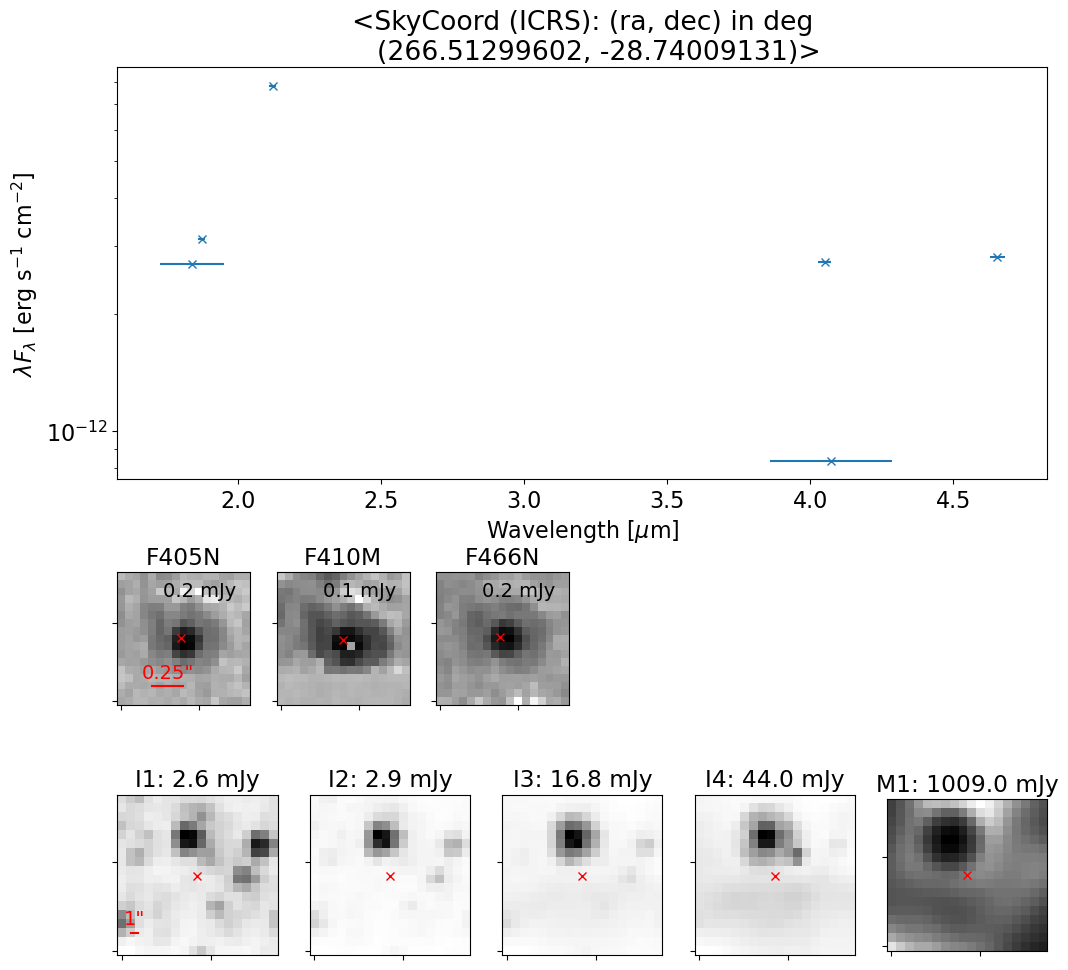

In [28]:
plot_tools.sed_and_starzoom_plot(basetable[blue_BrA_and_PaA]['skycoord_f410m'][0], basetable=basetable)

In [29]:
crd = basetable[blue_BrA_and_PaA]['skycoord_f410m'][0].galactic
f'JWST2221_G{crd.l.value:0.4f}{crd.b.value:+0.4f}'

'JWST2221_G0.2167+0.0213'

In [30]:
mkdir sed_plots

mkdir: cannot create directory ‘sed_plots’: File exists


In [31]:
from astropy import log

In [32]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
sys.path.append(f'{basepath}/reduction/')
import plot_tools
imp.reload(plot_tools)

<module 'plot_tools' from '/orange/adamginsburg/jwst/brick//analysis/plot_tools.py'>

<SkyCoord (ICRS): (ra, dec) in deg
    (266.51299602, -28.74009131)> <SkyCoord (Galactic): (l, b) in deg
    (0.21667335, 0.02131215)>
INFO: No matches for spitzer: list index out of range [plot_tools]
INFO: No VVV match [plot_tools]
<SkyCoord (ICRS): (ra, dec) in deg
    (266.51284751, -28.73313465)> <SkyCoord (Galactic): (l, b) in deg
    (0.22254667, 0.02504259)>
INFO: No matches for spitzer: list index out of range [plot_tools]
INFO: No VVV match [plot_tools]
<SkyCoord (ICRS): (ra, dec) in deg
    (266.51273067, -28.7266651)> <SkyCoord (Galactic): (l, b) in deg
    (0.22801844, 0.02849589)>
INFO: No matches for spitzer: list index out of range [plot_tools]
INFO: No VVV match [plot_tools]
<SkyCoord (ICRS): (ra, dec) in deg
    (266.51302962, -28.74175811)> <SkyCoord (Galactic): (l, b) in deg
    (0.21526521, 0.02041984)>
INFO: No matches for spitzer: list index out of range [plot_tools]
INFO: No VVV match [plot_tools]
<SkyCoord (ICRS): (ra, dec) in deg
    (266.51321657, -28.7360524

UnboundLocalError: local variable 'wavelengths' referenced before assignment

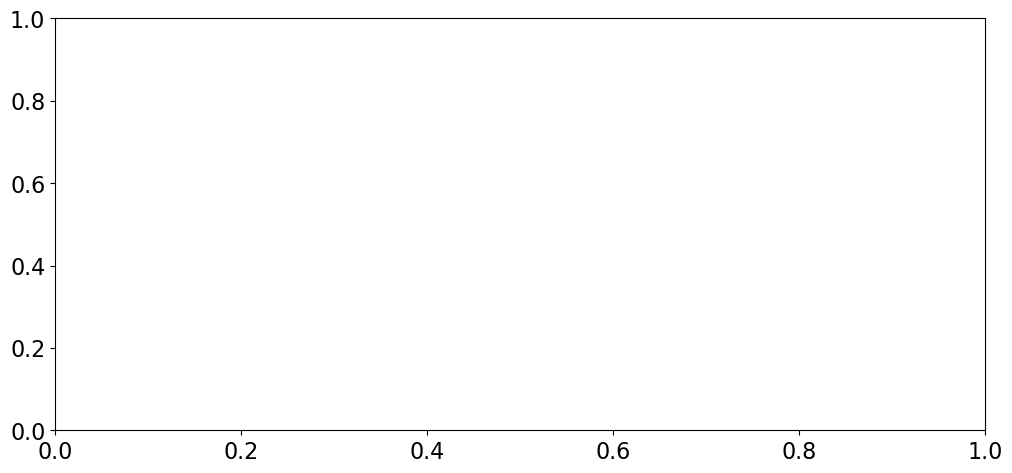

In [33]:
for crd in basetable[blue_BrA_and_PaA]['skycoord_f410m']:
    print(crd, crd.galactic)
    crd = crd.galactic
    with log.log_to_file('/dev/null'):
        name = f'JWST2221_G{crd.l.value:0.4f}{crd.b.value:+0.4f}'
        fig, _ = plot_tools.sed_and_starzoom_plot(crd, basetable=basetable, title=name)
        fig.savefig(f'{basepath}/sed_plots/{name}_SED.png', bbox_inches='tight')